### NLP system for creating Relevant Question and Answer based on job role

### <span style="color:#800000">Import libraries</span>

In [404]:
import pandas as pd
import numpy as np
import re
import html
import string
import unicodedata
import json
import ast
import random

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords

from nltk.tag import pos_tag
from nltk.chunk import ne_chunk

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

import collections
from collections import Counter
import matplotlib.pyplot as plt
from spacy.training import Example
import seaborn as sns

from spacy.util import minibatch, compounding
from pathlib import Path

import spacy
from spacy import displacy
import en_core_web_sm

pd.set_option('display.max_colwidth', None)

### <span style="color:#800000">Loading Datasets</span>

In [2]:
# Reading data and creating the dataframe 
job = pd.read_csv("F:\BITS\Capstone\Dataset\JobDescriptions.csv")

# Checking the first 5 rows of the data
job.head()

,job_role,title,description,tags,new_title
0,artificial intelligence,Leadership Role - Product Management - Artificial Intelligence - Mobile Apps (6-10 yrs),"<p>Opportunity for a Product Management position with the booming AI platform.\r<br/>\r<br/>Position: Product Manager_Mobile\r<br/>\r<br/>Domain: Artificial Intelligence_Product management\r<br/>\r<br/>Experience: 6+ Years (minimum 4 Years into product Management)\r<br/>\r<br/>Mandatory to have: Exposure in Mobile Product Management\r<br/>\r<br/>Job Responsibilities\r<br/>\r<br/>1. Defining the value proposition for the application. What value does the application promise its users- Why should people use this application and what value will users derive by using this application.\r<br/>\r<br/>2. Conduct extensive research of the domain to understand other similar applications available to consumers and their strengths and weaknesses; assess the gap between consumer expectations and what is available to them from competing applications.\r<br/>\r<br/>3. Define a distinctive positioning for the application in line with the value it provides to the end user, its unique features and functionality and differentiation from other such applications.\r<br/>\r<br/>4. Define a detailed list of features and functionality for the voice application, organize and prioritize them for implementation.\r<br/>\r<br/>5. Build wireframes for top-level conversation flow.\r<br/>\r<br/>6. Work with engineering teams and conversation designers. Work with conversation designers to improve the conversation quality and make conversations more human- like. Work with engineering teams to understand and leverage platform capabilities and features in order to create compelling conversational experiences that are human like.\r<br/>\r<br/>7. Research all data sources in specific domain areas to identify structured and unstructured data sources for the application.\r<br/>\r<br/>8. Identify the categories of questions that the application should be capable of answering in a domain. Work with the engineering team to identify sources of structured and unstructured data that will help in answering these questions. \r<br/>\r<br/>9. Create product notes and product specifications. Write product descriptions for the application on app stores. \r<br/>\r<br/>10. Review user feedback everyday, respond to user comments, address user issues, and prioritize bug fixes and product features based on user feedback.\r<br/>\r<br/>11. Create marketing content like demo videos and other content to demonstrate the capability of the application. Find effective ways to distribute this content to target audience.\r<br/>\r<br/>Skills and Qualifications:\r<br/>\r<br/>1. Ability to think from end-consumer's point of view. Understanding the customer deeply and ability to step into her/his shoes.\r<br/>\r<br/>2. Logical thinking ability to build wireframes and flowcharts for conversations and dialogs.\r<br/>\r<br/>3. Basic understanding of markup text editors like Sublime Text is desirable. People with logical thinking ability can learn this skill in a week's time.\r<br/>\r<br/>4. Knowledge of the application domain - recipes, basketball, cricket, movies, news etc.</p>","['IT Product Management', 'Artificial Intelligence', 'Online Product Management']",leadership role product management artificial intelligence mobile apps yrs
1,artificial intelligence,Head - Data Science & Emerging Artificial Intelligence (10-20 yrs),"<p>Basic Function / Job Responsibilities\r<br/>\r<br/>Operational/Executive Management\r<br/>\r<br/>- Define CoE strategy and roadmap to develop a vibrant DS & AI ecosystem in the country and realize the vision and objectives of\r<br/>\r<br/>- Identifies opportunities of collaboration. Adopt a - String of Pearls- approach to build a powerful eco-system of stakeholders across Innovators, Technology players, ISPs, Academia & Government for the enable the CoE to be the catalyst for innovation, research, adoption, and skill & t

In [3]:
job.shape

(105, 5)

In [31]:
#Cleaning and stripping HTML
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    cleantext = re.sub(clean, '', text)
    return cleantext

In [32]:
#Removing Escaping characters &lt
def escaping_html_char(doc):
    cleandoc = html.unescape(doc)
    return cleandoc

In [43]:
#Removing newline & extra spaces
def textcleaning(doc):
    # remove extra newlines
    a = doc.replace("\\n"," ").strip()
    a = a.replace("\\r"," ").strip()
    #a = re.sub(r'\d+','',a)# remove numbers
    cleandoc = re.sub("\s+"," ", a)
    return cleandoc

In [34]:
def text_norm(doc):
    cleandoc = doc.lower()
    return cleandoc

In [35]:
abbr_dict={
    "what's":"what is",
    "what're":"what are",
    "who's":"who is",
    "who're":"who are",
    "where's":"where is",
    "where're":"where are",
    "when's":"when is",
    "when're":"when are",
    "how's":"how is",
    "how're":"how are",

    "i'm":"i am",
    "we're":"we are",
    "you're":"you are",
    "they're":"they are",
    "it's":"it is",
    "he's":"he is",
    "she's":"she is",
    "that's":"that is",
    "there's":"there is",
    "there're":"there are",

    "i've":"i have",
    "we've":"we have",
    "you've":"you have",
    "they've":"they have",
    "who've":"who have",
    "would've":"would have",
    "not've":"not have",

    "i'll":"i will",
    "we'll":"we will",
    "you'll":"you will",
    "he'll":"he will",
    "she'll":"she will",
    "it'll":"it will",
    "they'll":"they will",

    "isn't":"is not",
    "wasn't":"was not",
    "aren't":"are not",
    "weren't":"were not",
    "can't":"can not",
    "couldn't":"could not",
    "don't":"do not",
    "didn't":"did not",
    "shouldn't":"should not",
    "wouldn't":"would not",
    "doesn't":"does not",
    "haven't":"have not",
    "hasn't":"has not",
    "hadn't":"had not",
    "won't":"will not"
}

def process_data(doc):
    for key, value in abbr_dict.items():
        doc = doc.replace(key,value)
    return doc



In [36]:
# Removing accented characters
# A simple example — converting é to e.
def decode_text(doc):
    cleandoc = unicodedata.normalize('NFKD', doc).encode('ascii','ignore').decode("utf8")
    return cleandoc

In [37]:
def text_tokenize(doc):
    return word_tokenize(doc)

In [38]:
def remove_stopwords(words):
    # set of stop words
    stop_words = set(stopwords.words('english')) 
    stext = [] 
    for w in words:
        if w not in stop_words:
            stext.append(w)
    return stext

In [39]:
def remove_punctuation(doc):
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    ##str.maketrans('', '', string.punctuation)
    cleandoc = doc.translate(table)
    return cleandoc

In [438]:
def data_preprocessing(doc,w_stop):

    doc = str(doc)
    
    step1 = remove_html_tags(doc)            # Cleaning and stripping HTML
    step2 = escaping_html_char(step1)        # Removing Escaping characters &lt
    step3 = textcleaning(step2)              # Removing newline & extra spaces
    step4 = text_norm(step3)                 # Case Normalization
    step5 = process_data(step4)              # Transforming abbreviations
    step6 = remove_punctuation(step5)        # Remove punctuation
    step7 = decode_text(step6)               # Text encoding - Removing accented characters
    step8 = text_tokenize(step7)             # Tokenization
    

    if w_stop:
        step11 = remove_stopwords(step8)
        cleandoc = " ".join(step11)
    else:
        cleandoc = " ".join(step8)
    
    return cleandoc

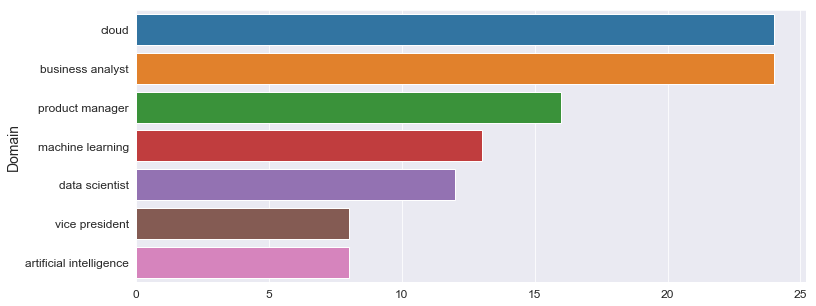

In [439]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(12, 5))

# split() returns list of all the words in the string
roles = job['job_role'].value_counts() 

sns.barplot(y=roles.index, x=roles.values, ax=ax)
ax.set_ylabel('Domain', fontsize=14)
ax.tick_params(labelsize=12)

In [440]:
job['Clean_description'] = job['description'].apply(data_preprocessing,w_stop=True)

def get_bigram(doc):
    nltk_tokens = nltk.word_tokenize(doc)
    result = list(nltk.bigrams(nltk_tokens))
    return result

bi = job['Clean_description'].apply(get_bigram)


In [441]:
words = job['Clean_description'].apply(nltk.word_tokenize)

onegrams = []
for i in words:
    onegrams.extend(i)


# get the frequency of each bigram in our corpus
wordFreq = collections.Counter(onegrams)

onedf = pd.DataFrame.from_dict(wordFreq,orient='index',columns=['Count']).reset_index()
onedf.rename(columns={"index": "bigram"},inplace=True)
onedf.sort_values(by='Count', ascending=False,inplace=True)

topone = onedf[onedf.Count>10]

In [94]:
esBigrams = []
for i in bi:
    esBigrams.extend(i)

lst = []
for j in esBigrams:
    lst.append(j[0]+" "+j[1])
    
 # get the frequency of each bigram in our corpus
esBigramFreq = collections.Counter(lst)

# what are the ten most popular ngrams in this Spanish corpus?
esBigramFreq.most_common(30) 

bidf = pd.DataFrame.from_dict(esBigramFreq,orient='index',columns=['Count']).reset_index()
bidf.rename(columns={"index": "bigram"},inplace=True)
bidf.sort_values(by='Count', ascending=False,inplace=True)

topbi = bidf[bidf.Count>10]
#job[(job.title.str.contains("Recruitment")) & (job.title.str.contains("Learning"))]

In [107]:
#pd.DataFrame(topone).to_csv('F:\BITS\Capstone\Dataset\Mytags1.csv',index=False)
#pd.DataFrame(topbi).to_csv('F:\BITS\Capstone\Dataset\Mytags2.csv',index=False)

In [344]:
mtags = pd.read_csv('F:\BITS\Capstone\Dataset\Mytags2.csv')

In [442]:
obdesc = job['Clean_description'][0]

def auto_tags(doc,domain):
    d = dict()
    l = []
    ws = []
    st = []
    for m in mtags.to_numpy():
        w,t = m[0],m[2]
        if doc.find(w)>=0:
            for f in re.finditer(w, doc):
                if w not in ws:                
                    ws.append(w)
                    count = len([i for i in st if i > f.start()]) 
                    if count == 0:
                        st.append(f.end())
                        a = tuple([f.start(),f.end(),t.upper()])
                        l.append(a)
    #l.append((0,len(domain),'DOMAIN'))
    d['entities'] = l
    return d

#auto_tags(obdesc,'AI')

In [443]:
job['Tags'] = job.apply(lambda x: auto_tags(x['Clean_description'], x['job_role']), axis=1)

In [444]:
cols = ['domain','title','description','clean_description','tags']
new_job = job[['job_role','title','description','Clean_description','Tags']]
new_job.columns = cols

In [445]:
new_job.to_csv('jobdescription_train.csv',index=False)

In [481]:
df = pd.read_csv('jobdescription_train.csv')

df['clean_description'] = df['clean_description'].str.replace('^ +', '_')
TRAIN_DATA = df[['clean_description','tags']].to_numpy()

In [459]:
# Import and load the spacy model
import spacy
nlp=spacy.load("en_core_web_sm") 

# Getting the ner component
ner=nlp.get_pipe('ner')

# Adding labels to the `ner`
ner.add_label('SKILLS')
ner.add_label('ROLES')

# Disable pipeline components you dont need to change
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
unaffected_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

In [460]:
def train_spacy(data,iterations):
    TRAIN_DATA = data
    nlp = spacy.blank('en')  # create blank Language class
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'ner' not in nlp.pipe_names:
        nlp.add_pipe('ner', last=True)
       

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        optimizer = nlp.begin_training()
        for itn in range(iterations):
            print("Statring iteration " + str(itn))
            random.shuffle(TRAIN_DATA)
            losses = {}
            batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
            for batch in batches:
                examples = []
                for text, annots in batch:
                    annots = ast.literal_eval(annots)
                    examples.append(Example.from_dict(nlp.make_doc(text), annots))
                    nlp.update(examples,losses=losses)
                print("Losses", losses) 
    return nlp

In [492]:
prdnlp = train_spacy(TRAIN_DATA, 1)

Statring iteration 0
Losses {'ner': 1984.068860411644}
Losses {'ner': 2608.2187490463257}
Losses {'ner': 2725.592136845966}
Losses {'ner': 2800.868847517572}


D:\Python\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "experience 10 years education mba front line busin..." with entities "[(0, 10, 'SKILLS'), (45, 53, 'ROLES'), (1323, 1327...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2899.8216269360805}
Losses {'ner': 2975.05988764483}


D:\Python\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "roles responsibilities lead drive engineering life..." with entities "[(488, 506, 'ROLES'), (526, 530, 'ROLES'), (705, 7...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3046.144230709759}


D:\Python\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "job purpose extracting patterns insights data appl..." with entities "[(125, 141, 'SKILLS'), (683, 699, 'SKILLS'), (765,...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
D:\Python\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "looking sr manager machine learning exposure retai..." with entities "[(19, 35, 'SKILLS'), (505, 513, 'SKILLS'), (624, 6...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
D:\Python\lib\site-packages\spacy\training\i

Losses {'ner': 3207.557142405856}


D:\Python\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "experience 10 years education mba front line busin..." with entities "[(0, 10, 'SKILLS'), (45, 53, 'ROLES'), (1323, 1327...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
D:\Python\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "experience 10 years education mba front line busin..." with entities "[(0, 10, 'SKILLS'), (45, 53, 'ROLES'), (1323, 1327...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3603.2340438748633}


D:\Python\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "job purpose extracting patterns insights data appl..." with entities "[(125, 141, 'SKILLS'), (683, 699, 'SKILLS'), (765,...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3690.886217469875}


D:\Python\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "location gurgaon bengaluru mumbaiqualification bac..." with entities "[(706, 715, 'SKILLS'), (975, 985, 'ROLES'), (1106,...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3744.198461147039}


D:\Python\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "data scientist iit dse iims looking self driven py..." with entities "[(0, 14, 'SKILLS'), (81, 91, 'SKILLS'), (405, 407,...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3812.1240166246557}


D:\Python\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "data scientist iit dse iims looking self driven py..." with entities "[(0, 14, 'SKILLS'), (81, 91, 'SKILLS'), (405, 407,...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3891.1453227424217}
Losses {'ner': 3935.2506863731583}


D:\Python\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "sales director marketing cloud role sales director..." with entities "[(692, 712, 'ROLES'), (822, 832, 'SKILLS'), (1215,...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
D:\Python\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "must experience cloud architecture planning must p..." with entities "[(5, 15, 'SKILLS'), (54, 58, 'ROLES'), (240, 249, ...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
D:\Python\lib\site-packages\spacy\training\i

Losses {'ner': 4005.4119356855317}


D:\Python\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "looking vp machine learning retail banking nbfc gu..." with entities "[(11, 27, 'SKILLS'), (624, 632, 'SKILLS'), (697, 7...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
D:\Python\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "leadership opportunity cloud solution architect in..." with entities "[(352, 361, 'SKILLS'), (362, 372, 'SKILLS'), (1381...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4073.17129550593}


D:\Python\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "job descriptionwe looking data scientist help us d..." with entities "[(319, 335, 'SKILLS'), (1107, 1117, 'SKILLS'), (15...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4129.813010145428}


D:\Python\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "looking sr manager machine learning exposure retai..." with entities "[(19, 35, 'SKILLS'), (505, 513, 'SKILLS'), (624, 6...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
D:\Python\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "looking sr manager machine learning exposure retai..." with entities "[(19, 35, 'SKILLS'), (505, 513, 'SKILLS'), (624, 6...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4195.348480692301}


D:\Python\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "10 15 years industry experience covering cloud lan..." with entities "[(21, 31, 'SKILLS'), (75, 79, 'SKILLS'), (482, 493...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4233.945418897434}
Losses {'ner': 4271.196571368437}
Losses {'ner': 4305.505945554821}


D:\Python\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "experience 10 years education mba front line busin..." with entities "[(0, 10, 'SKILLS'), (45, 53, 'ROLES'), (1323, 1327...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4343.911357353274}


D:\Python\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "roles responsibilities lead drive engineering life..." with entities "[(488, 506, 'ROLES'), (526, 530, 'ROLES'), (705, 7...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4366.910396225345}
Losses {'ner': 4423.007264273172}


D:\Python\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "job purpose extracting patterns insights data appl..." with entities "[(125, 141, 'SKILLS'), (683, 699, 'SKILLS'), (765,...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4487.974025577538}


D:\Python\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "job description 6 years relevant work experience m..." with entities "[(49, 65, 'SKILLS'), (174, 182, 'SKILLS'), (574, 5...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
D:\Python\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "organization exciting start around founded best in..." with entities "[(354, 372, 'ROLES'), (449, 453, 'ROLES'), (506, 5...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
D:\Python\lib\site-packages\spacy\training\i

Losses {'ner': 4520.2493002844785}
Losses {'ner': 4526.536318935855}
